In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import nltk
from gensim.models import Word2Vec

# Download necessary resources for NLTK
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Text labels corresponding to digits
text_labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Download necessary resources for NLTK if not already done
# try:
#     nltk.data.find('tokenizers/punkt_tab')
# except nltk.downloader.DownloadError:
#     nltk.download('punkt_tab')

# Tokenize text labels using NLTK tokenizer
tokenized_labels = [nltk.word_tokenize(label) for label in text_labels]

# Train a Word2Vec model on the tokenized labels
word2vec_model = Word2Vec(sentences=tokenized_labels, vector_size=10, window=1, min_count=1, sg=0)

# Extract Word2Vec embeddings for each label
label_embeddings = {label: word2vec_model.wv[label] for label in text_labels}

# Print example embedding for 'zero'
print("Embedding for 'zero':", label_embeddings['zero'])

Embedding for 'zero': [ 0.01631476  0.00189917  0.03473637  0.00217777  0.09618826  0.05060603
 -0.0891739  -0.0704156   0.00901456  0.06392534]


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, embed_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28 + embed_dim, 400)  # Image and label embedding
        self.fc2_mean = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)

    def forward(self, x, label_emb):
        # Concatenate image and label embedding
        x = torch.cat((x.view(-1, 28 * 28), label_emb), dim=-1)
        x = torch.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, embed_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + embed_dim, 400)
        self.fc2 = nn.Linear(400, 28 * 28)

    def forward(self, z, label_emb):
        # Concatenate latent vector and label embedding
        z = torch.cat((z, label_emb), dim=-1)
        x = torch.relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(x))
        return x.view(-1, 28, 28)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, embed_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim, embed_dim)
        self.decoder = Decoder(latent_dim, embed_dim)

    def reparameterize(self, mean, logvar):
        # Sampling from a normal distribution using reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, label_emb):
        mean, logvar = self.encoder(x, label_emb)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z, label_emb)
        return recon_x, mean, logvar

In [ ]:
def loss_function(recon_x, x, mean, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')

    # KL divergence
    KL_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + KL_div

In [ ]:
# Data Preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]


In [ ]:
latent_dim = 20
embed_dim = 10  # Dimension of label embedding (Word2Vec dimension)
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(latent_dim, embed_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Map numeric labels to Word2Vec embeddings
        label_emb = torch.stack([torch.tensor(label_embeddings[text_labels[label]], dtype=torch.float32) for label in target]).to(device)

        # Forward pass
        recon_batch, mean, logvar = model(data, label_emb)

        # Compute the loss
        loss = loss_function(recon_batch, data, mean, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset)}")

Epoch [1/100], Loss: 166.10669086914064
Epoch [2/100], Loss: 121.60055032552083
Epoch [3/100], Loss: 114.2565298828125
Epoch [4/100], Loss: 111.04694052734375
Epoch [5/100], Loss: 109.12568870442708
Epoch [6/100], Loss: 107.87543076171875
Epoch [7/100], Loss: 106.92393686523438
Epoch [8/100], Loss: 106.24434977213542
Epoch [9/100], Loss: 105.63848917643229
Epoch [10/100], Loss: 105.16149633789063
Epoch [11/100], Loss: 104.68900366210937
Epoch [12/100], Loss: 104.39230983072916
Epoch [13/100], Loss: 104.08540071614583
Epoch [14/100], Loss: 103.78125738932292
Epoch [15/100], Loss: 103.50324695638021
Epoch [16/100], Loss: 103.29700050455729
Epoch [17/100], Loss: 103.05783165690104
Epoch [18/100], Loss: 102.84316310221354
Epoch [19/100], Loss: 102.62485485026042
Epoch [20/100], Loss: 102.49925493164062
Epoch [21/100], Loss: 102.29281292317708
Epoch [22/100], Loss: 102.16070696614584
Epoch [23/100], Loss: 101.93539055989584
Epoch [24/100], Loss: 101.83153461914063
Epoch [25/100], Loss: 101.

In [ ]:
def generate_image(model, label_text, latent_dim=20):
    model.eval()
    with torch.no_grad():
        # Convert label to Word2Vec embedding
        label_emb = torch.tensor(label_embeddings[label_text],
                                 dtype=torch.float32).unsqueeze(0).to(device)
        # Generate random latent vector
        z = torch.randn(1, latent_dim).to(device)

        generated_image = model.decoder(z, label_emb).cpu().numpy().reshape(28, 28)

    plt.imshow(generated_image, cmap='gray')
    plt.title(f"Generated Image for Label: {label_text}")
    plt.show()

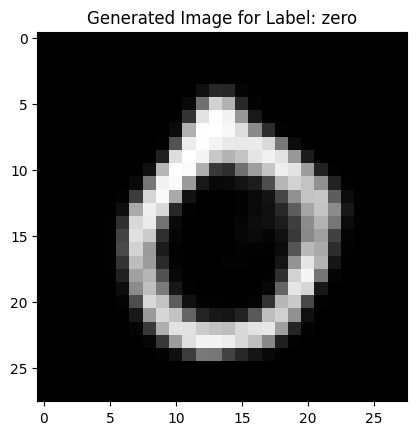

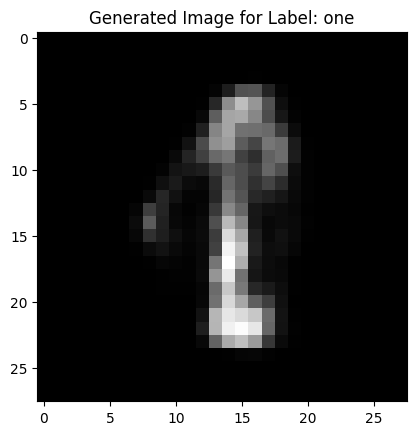

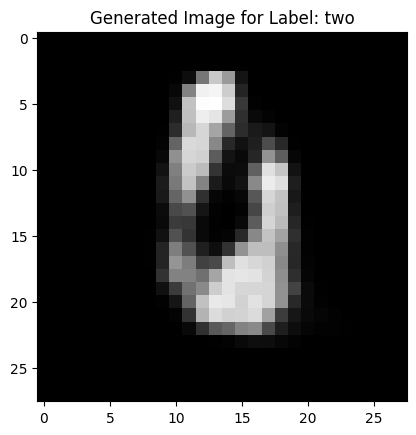

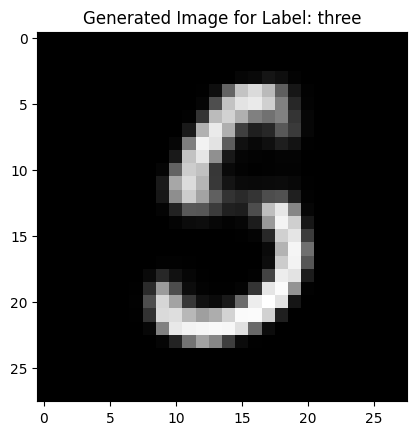

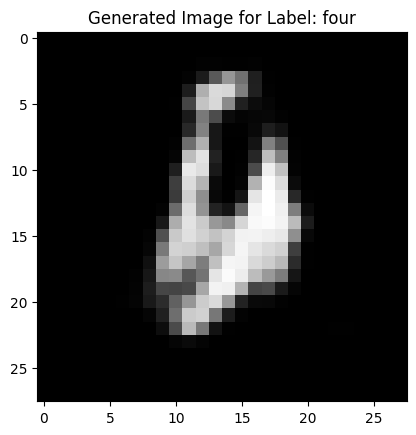

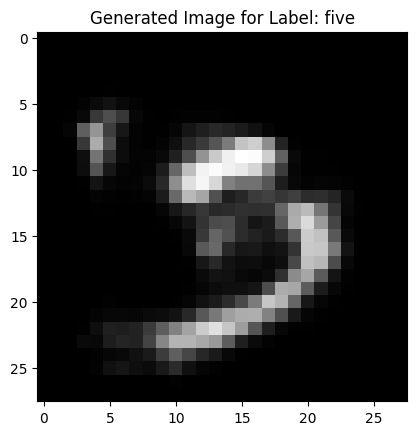

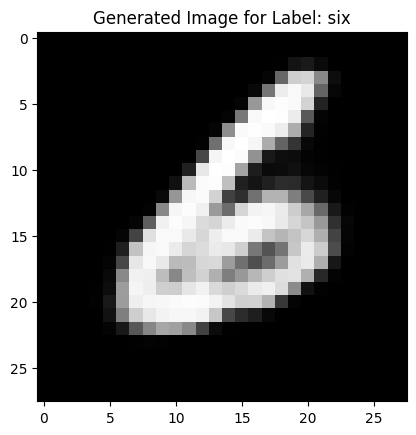

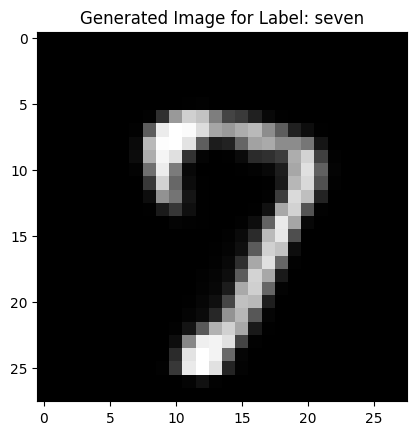

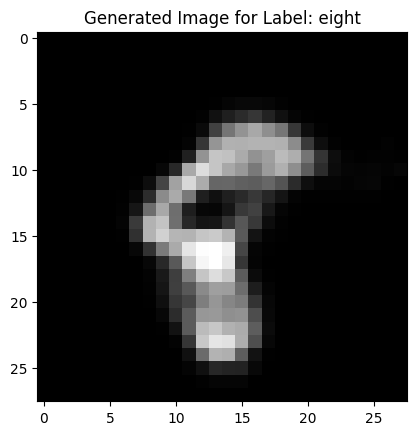

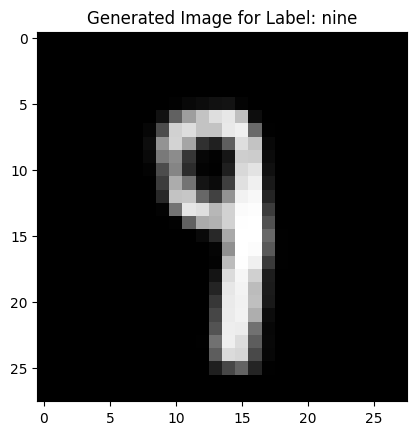

In [ ]:
# Generate images for each label
for label in text_labels:
    generate_image(model, label)